In [ ]:
import torch
import torch.nn as nn

In [ ]:
!gdown 1kTEftRBxz_dpMCcl8-JSOoGvD1yQBdvO
!gdown 1tADa7tvzVq5Lj7tDsYaHZY_i2ff8I-7E

Downloading...
From (original): https://drive.google.com/uc?id=1kTEftRBxz_dpMCcl8-JSOoGvD1yQBdvO
From (redirected): https://drive.google.com/uc?id=1kTEftRBxz_dpMCcl8-JSOoGvD1yQBdvO&confirm=t&uuid=50349732-0951-45fc-98e2-160c555fdef3
To: /content/COST_X_train.pt
100% 768M/768M [00:06<00:00, 112MB/s]
Downloading...
From: https://drive.google.com/uc?id=1tADa7tvzVq5Lj7tDsYaHZY_i2ff8I-7E
To: /content/COST_y_train.pt
100% 241k/241k [00:00<00:00, 80.7MB/s]


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('Chosen device:', device)

Chosen device: cuda


In [ ]:
X_train = torch.load('COST_X_train.pt')
X_train.shape

torch.Size([15000, 64, 100, 2])

In [ ]:
Y_train = torch.load('COST_y_train.pt')
Y_train.shape

torch.Size([15000, 2])

## Autoencoder

In [ ]:
X = X_train[::1]
Y = Y_train[::1]

X = X.permute(0, 3, 1, 2)

print(X.shape, Y.shape)

torch.Size([15000, 2, 64, 100]) torch.Size([15000, 2])


In [ ]:
# BASIC 2

class Autoencoder2D(nn.Module):
    def __init__(self):
        super(Autoencoder2D, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(2, 16, kernel_size=3, stride=2, padding=1),  # 16x32x50
            nn.ReLU(True),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),  # 32x16x25
            nn.ReLU(True),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # 64x8x13
            nn.ReLU(True)
        )


        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # 32x16x26
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),  # 16x32x52
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 2, kernel_size=3, stride=2, padding=(1, 3), output_padding=1),  # 2x64x104
#             nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


model = Autoencoder2D()


print(model)


Autoencoder2D(
  (encoder): Sequential(
    (0): Conv2d(2, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU(inplace=True)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(16, 2, kernel_size=(3, 3), stride=(2, 2), padding=(1, 3), output_padding=(1, 1))
  )
)


In [ ]:
model(X).shape

torch.Size([15000, 2, 64, 100])

In [ ]:
model.to(device)

Autoencoder2D(
  (encoder): Sequential(
    (0): Conv2d(2, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU(inplace=True)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(16, 2, kernel_size=(3, 3), stride=(2, 2), padding=(1, 3), output_padding=(1, 1))
  )
)

In [ ]:
from torch.utils.data import DataLoader, TensorDataset

# Assuming X and Y are your input and output tensors respectively

# Create a TensorDataset
dataset = TensorDataset(X, Y)

# Define batch size
batch_size = 30

# Create DataLoader objects for handling batches
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


In [ ]:
history = []

In [ ]:
# Define your loss function
criterion = nn.MSELoss()

# Hyperparam for fft loss
lambda_fft = 100000

# Define your optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    total_loss = 0
    total_loss_ = 0
    total_loss_fft = 0
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        batch_x = batch_x.to(device)
        output = model(batch_x)

        output_fft_complex = torch.fft.fft(output)
        output_fft = output_fft_complex.real**2 + output_fft_complex.imag**2

        batch_x_fft_complex = torch.fft.fft(batch_x)
        batch_x_fft = batch_x_fft_complex.real**2 + batch_x_fft_complex.imag**2

        loss_ = criterion(output, batch_x)
        loss_fft = criterion(output_fft, batch_x_fft)/lambda_fft
        loss = loss_ + loss_fft
        loss = loss_fft
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_loss_ += loss_.item()
        total_loss_fft += loss_fft.item()
    history.append(total_loss)
    print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader)}    [Loss_: {total_loss_ / len(train_loader)} | Loss_fft: {total_loss_fft / len(train_loader)}]")


Epoch 1, Loss: 0.5394026381373406    [Loss_: 0.3854860299527645 | Loss_fft: 0.5394026381373406]
Epoch 2, Loss: 0.530342406630516    [Loss_: 0.3893544900417328 | Loss_fft: 0.530342406630516]
Epoch 3, Loss: 0.52993875092268    [Loss_: 0.3894503166079521 | Loss_fft: 0.52993875092268]
Epoch 4, Loss: 0.5299781702160835    [Loss_: 0.3893807049393654 | Loss_fft: 0.5299781702160835]
Epoch 5, Loss: 0.5302072812914849    [Loss_: 0.38931241577863696 | Loss_fft: 0.5302072812914849]
Epoch 6, Loss: 0.5300673394203186    [Loss_: 0.38932816964387895 | Loss_fft: 0.5300673394203186]
Epoch 7, Loss: 0.5298946593999863    [Loss_: 0.38934435230493547 | Loss_fft: 0.5298946593999863]
Epoch 8, Loss: 0.529867200255394    [Loss_: 0.38930027437210085 | Loss_fft: 0.529867200255394]
Epoch 9, Loss: 0.5300039167404175    [Loss_: 0.3894102301597595 | Loss_fft: 0.5300039167404175]
Epoch 10, Loss: 0.5298643317222596    [Loss_: 0.38935847514867783 | Loss_fft: 0.5298643317222596]
Epoch 11, Loss: 0.5298205445408821    [Los

In [ ]:
import matplotlib.pyplot as plt

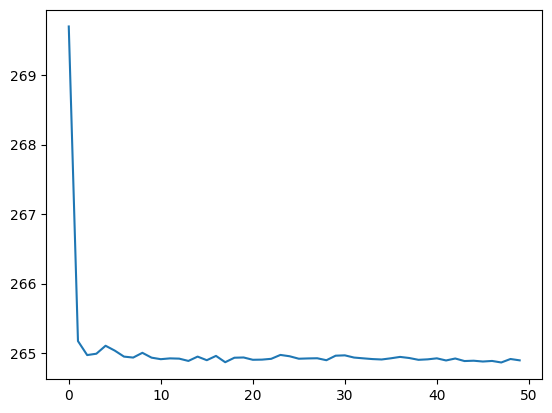

In [ ]:
plt.plot(history[0:])

In [ ]:
model_basic = model
model_basic

Autoencoder2D(
  (encoder): Sequential(
    (0): Conv2d(2, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU(inplace=True)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(16, 2, kernel_size=(3, 3), stride=(2, 2), padding=(1, 3), output_padding=(1, 1))
  )
)

In [ ]:
model_main = model

In [ ]:
try:
    X_enc_main = X_enc
except:
    2

In [ ]:
samplegap = 10

In [ ]:
X_train = X_train.to('cpu')

In [ ]:
with torch.no_grad():
    X_enc = model_main.to('cpu').encoder(X_train[::1].permute(0, 3, 1, 2))
print(X_enc.shape)
X_enc = torch.flatten(X_enc, start_dim =1)
print(X_enc.shape)

torch.Size([15000, 64, 8, 13])
torch.Size([15000, 6656])


In [ ]:
X_enc.device

device(type='cpu')

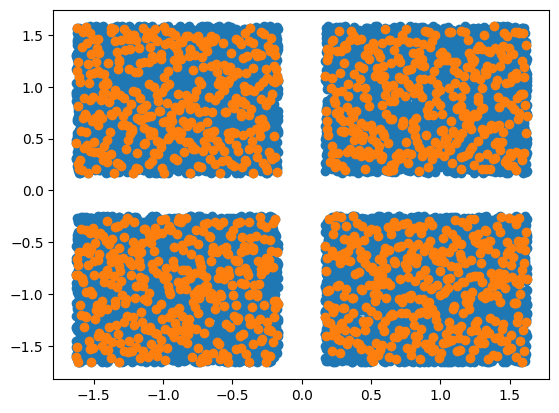

torch.Size([1500, 6656])


In [ ]:
plt.scatter(Y_train[:, 0], Y_train[:, 1])
plt.scatter(Y_train[::samplegap, 0], Y_train[::samplegap, 1])

plt.show()

print(X_enc[::samplegap].shape)

In [ ]:
torch.save(model_main, 'model_main_fft.pth')

In [ ]:
torch.save(model_main.state_dict, 'model_main_fft_state_dict.pt')

In [ ]:
model_main

Autoencoder2D(
  (encoder): Sequential(
    (0): Conv2d(2, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU(inplace=True)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(16, 2, kernel_size=(3, 3), stride=(2, 2), padding=(1, 3), output_padding=(1, 1))
  )
)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators=10, max_depth=20)
model.fit(X_enc[::samplegap], Y_train[::samplegap])

RandomForestRegressor(max_depth=20, n_estimators=10)

In [ ]:
Y_pred = model.predict(X_enc)

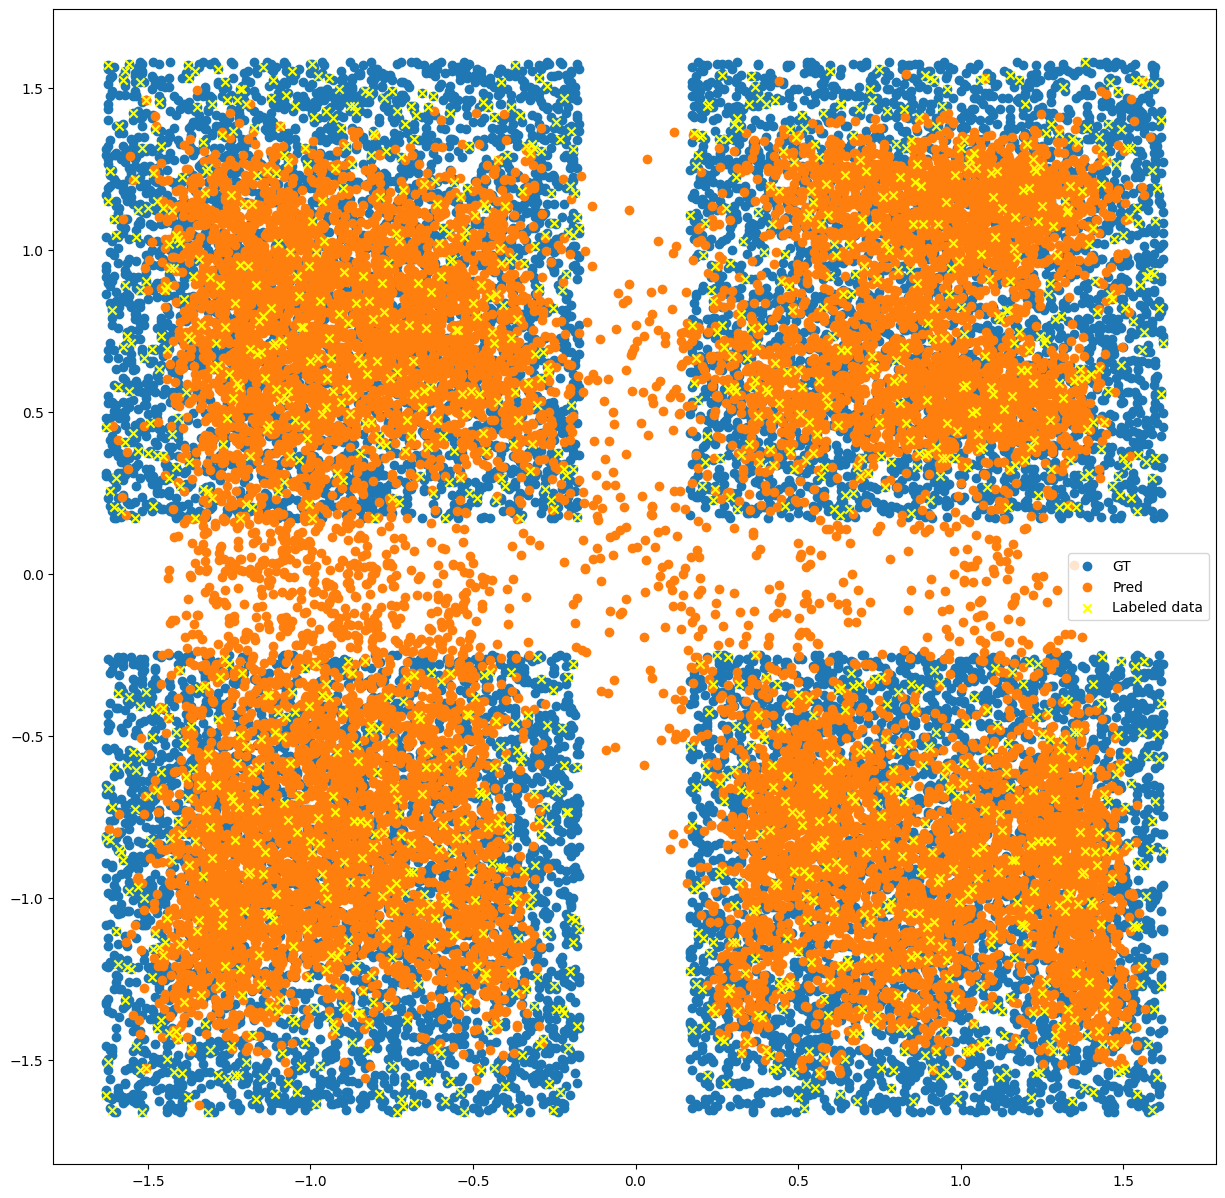

In [ ]:
plt.figure(figsize = (15, 15))
plt.scatter(Y_train[:, 0], Y_train[:, 1], label = "GT")


plt.scatter(Y_pred[:, 0], Y_pred[:, 1], label = "Pred")

plt.scatter(Y_train[::samplegap, 0], Y_train[::samplegap, 1], label = "Labeled data", marker = 'x', color = 'yellow')

plt.legend()
plt.show()

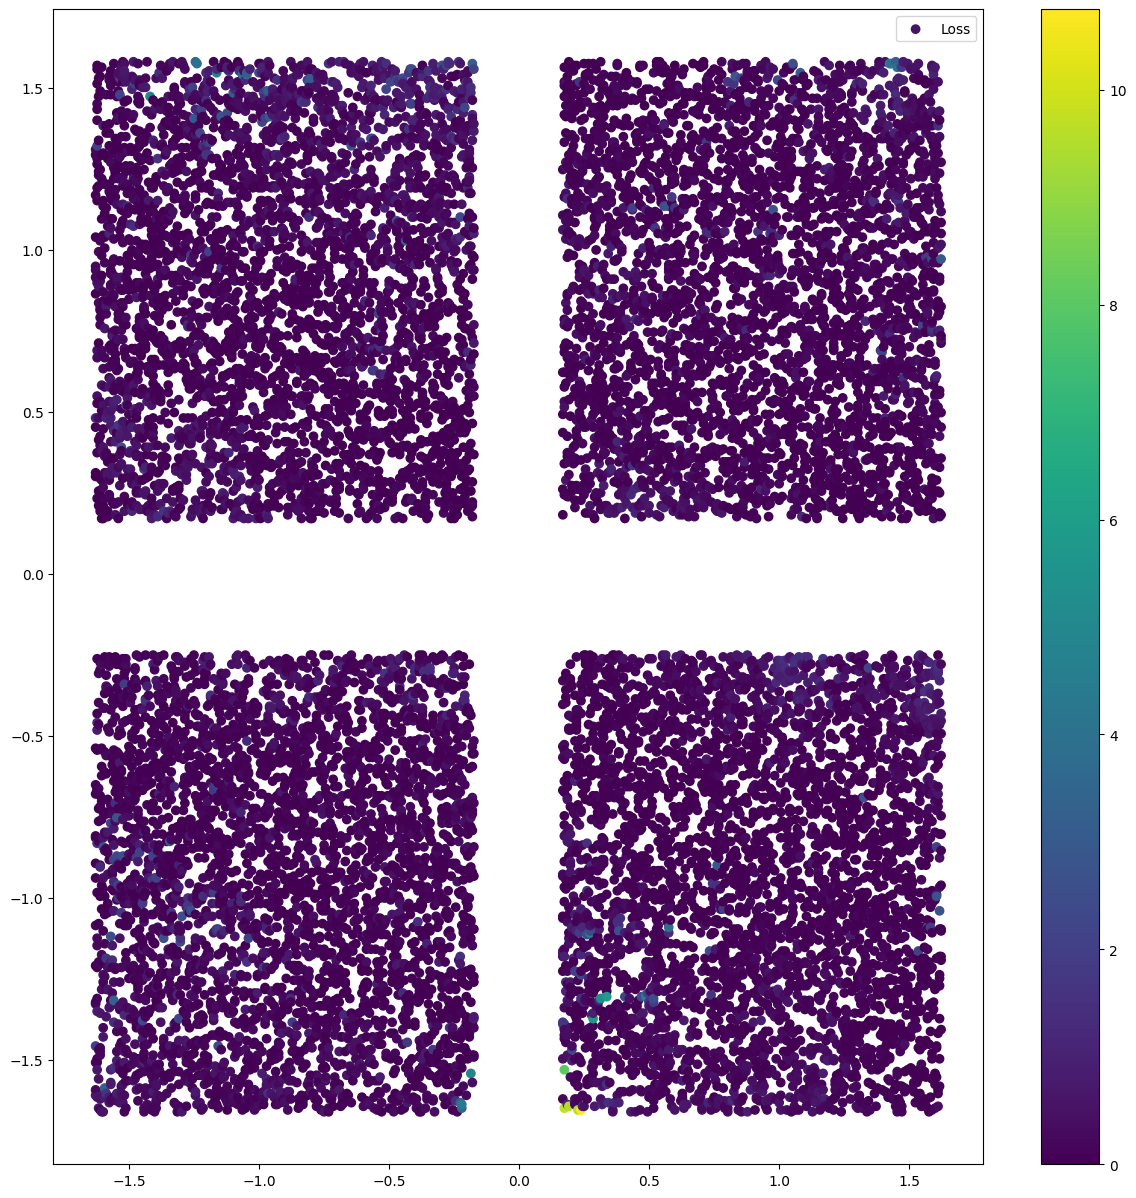

In [ ]:
plt.figure(figsize = (15, 15))
# plt.scatter(Y_train[:, 0], Y_train[:, 1], label = "GT")


# plt.scatter(Y_pred[:, 0], Y_pred[:, 1], label = "Pred")
plt.scatter(Y_train[:, 0], Y_train[:, 1], label = "Loss", c = np.sum(Y_pred - Y_train.numpy(), axis = 1)**2)
# plt.scatter(Y_train[::samplegap, 0], Y_train[::samplegap, 1], label = "Labeled data", marker = 'x', color = 'yellow')
plt.colorbar()

plt.legend()
plt.show()

In [ ]:
model = RandomForestRegressor(n_estimators=10, max_depth=20)
model.fit(X_enc, Y_train)

RandomForestRegressor(max_depth=20, n_estimators=10)

In [ ]:
Y_pred = model.predict(X_enc)

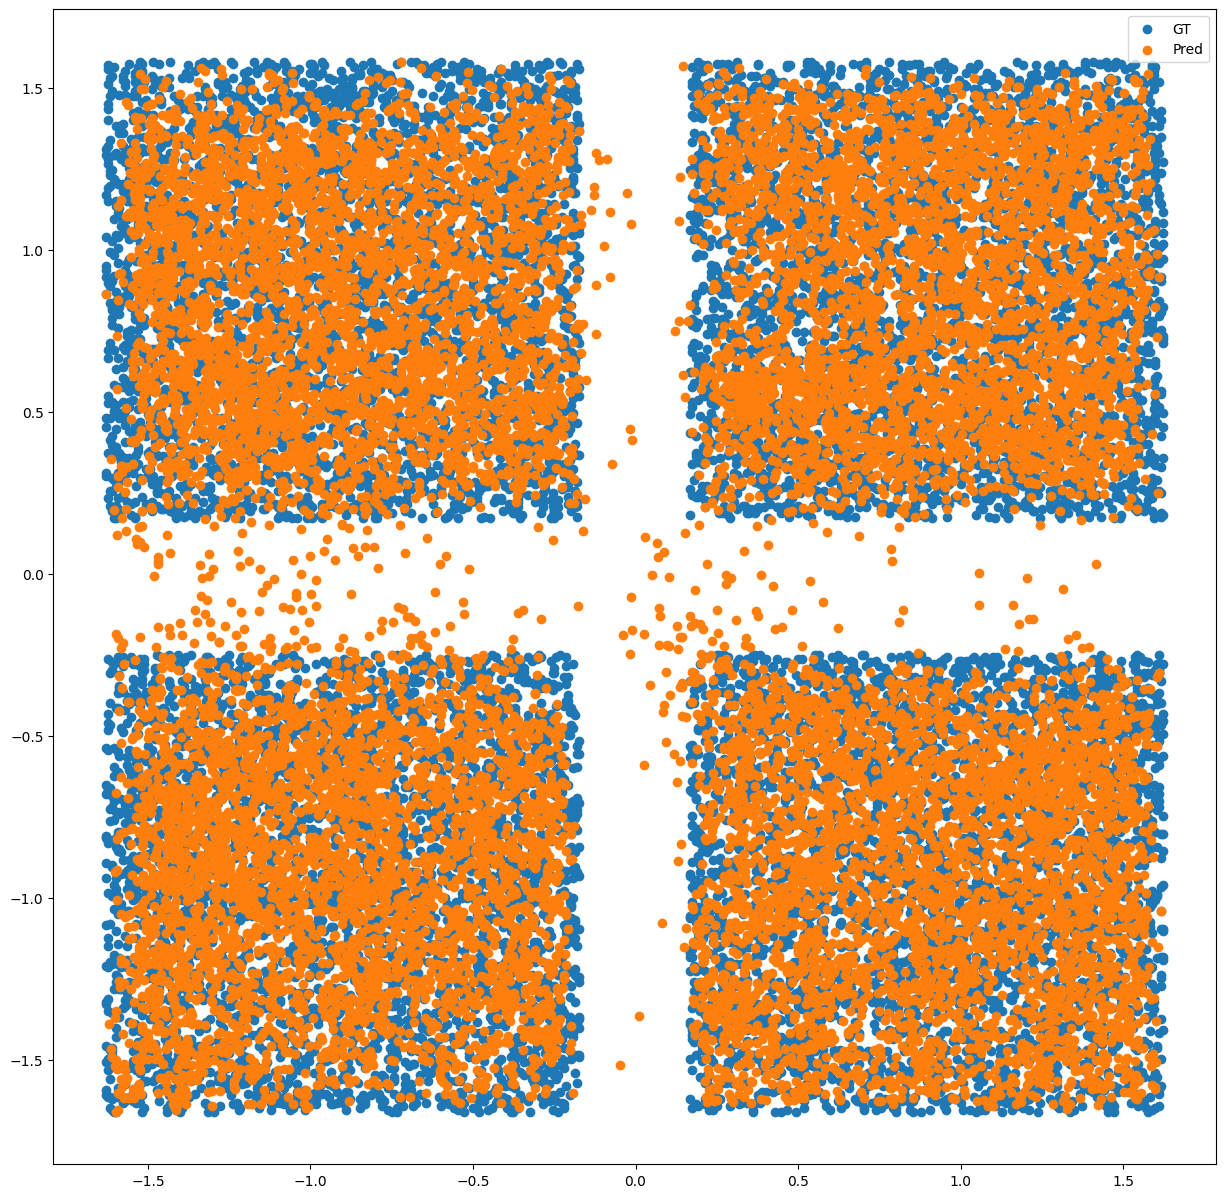

In [ ]:
plt.figure(figsize = (15, 15))
plt.scatter(Y_train[:, 0], Y_train[:, 1], label = "GT")


plt.scatter(Y_pred[:, 0], Y_pred[:, 1], label = "Pred")

plt.legend()
plt.show()